<h1> Load Data </h1>

In [11]:
# -- Import --
import sys
sys.path.append("/home/puguix/Desktop/cryptoBot/data_polo/utility/")

import pandas as pd
from get_data import get_historical_from_db
import ta
import numpy as np
from math import *

# - - Load data from database --
df = get_historical_from_db("Binance","ETH/USDT","5m")

print("Data loaded 100%")


Data loaded 100%


<h1>Define indicators </h1>

In [10]:
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)


# - - UT Bot Alerts - -

def UTBotAlerts(df,sensitivity, period):
    close = df['close']
    xATR = ta.volatility.average_true_range(df['high'], df['low'], close, period)
    n = close.size
    nLoss = [sensitivity] * n
    trailingStop, pos = [0] * n, [0] * n
    above, below = [False] * n, [False] * n
    buy, sell = [False] * n, [False] * n
    
    ema = ta.trend.ema_indicator(close, window=1)
        
    for curr in range(1, n):
        nLoss[curr] *= xATR.iloc[curr]
        prev = curr - 1
        if ((close.iloc[curr] > trailingStop[prev]) & (close.iloc[prev] > trailingStop[prev])):
            trailingStop[curr] = np.maximum(trailingStop[prev], close.iloc[curr] - nLoss[curr])
        elif ((close.iloc[curr] < trailingStop[prev]) & (close.iloc[prev] < trailingStop[prev])):
            trailingStop[curr] = np.minimum(trailingStop[prev], close.iloc[curr] + nLoss[curr])
        elif (close.iloc[curr] > trailingStop[prev]):
            trailingStop[curr] = close.iloc[curr] - nLoss[curr]
        else:
            trailingStop[curr] = close.iloc[curr] + nLoss[curr]
            
        if ((close.iloc[prev] < trailingStop[prev]) & (close.iloc[curr] > trailingStop[prev])):
            pos[curr] = 1
        elif ((close.iloc[prev] > trailingStop[prev]) & (close.iloc[curr] < trailingStop[prev])):
            pos[curr] = -1
        else:
            pos[curr] = pos[prev]
            
        above[curr] = (ema[curr] > trailingStop[curr]) & (ema[prev] < trailingStop[prev])
        below[curr] = (ema[curr] < trailingStop[curr]) & (ema[prev] > trailingStop[prev])
        
        buy[curr] = (close[curr] > trailingStop[curr]) & (above[curr])
        sell[curr] = (close[curr] < trailingStop[curr]) & (below[curr])
           
    return pd.DataFrame({'buy': buy, 'sell': sell})
    
# - - fonctions utilitaires - -

def lowest (values, current, length):
    min = values[current]
    for k in range(1, length):
        min = values[current - k] if values[current - k] < min else min
    return min

def highest (values, current, length):
    max = values[current]
    for k in range(1, length):
        max = values[current - k] if values[current - k] > max else max
    return max
    
    
# - - STC - -

def STC(df, length, fastLength, slowLength):

    close = df['close']
    n = close.size
    
    k = [0] * n
    kd = [0] * n
    mColor = ["red"] * n
    
    macd = ta.trend.ema_indicator(close, fastLength) - ta.trend.ema_indicator(close, slowLength)
    
    for curr in range(1, n):
        k[curr] = 100 * (macd[curr] - lowest(macd, curr, length)) / (highest(macd, curr, length) - lowest(macd, curr, length))

    d = ta.trend.ema_indicator(macd, 3)
    
    for curr in range(1, n):
        kd[curr] = 100 * (d.iloc[curr] - lowest(d, curr, length)) / (highest(d, curr, length) - lowest(d, curr, length))

    schaffTrend = ta.trend.ema_indicator(pd.Series(kd), 3)
    
    mColor[curr] = "green" if schaffTrend.iloc[curr] > schaffTrend.iloc[curr - 1] else "red"
        
    return pd.DataFrame({'STC': schaffTrend, 'color': mColor})
   
    
# - - Hull Suite - -

def HullSuite(df, length):
    close = df['close']
    
    def HMA(src, length):
        return ta.trend.wma_indicator(2 * ta.trend.wma_indicator(src, window=length // 2, fillna=False) - ta.trend.wma_indicator(src, window=length, fillna=False), window=round(length ** (1/2)), fillna=False)
    
    HULL = HMA(close, length)
    
    hColor = ["red"] * close.size
    for curr in range(1, close.size):
        hColor[curr] = "green" if HULL[curr] > HULL[curr -2] else "red"
    
    
    return pd.DataFrame({'hColor': hColor, 'hull': HULL})
    
print("Indicators loaded")

Indicators loaded


/tmp/ipykernel_128951/4210816674.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)


<h1> Optimizer </h1>

In [57]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['sensitivity','period', 'length', 'fastLength', 'slowLength', 'hLength', 'result'])


# -- Condition to LONG market --
def openLongCondition(row, previousRow):
    # return row['buy'] and row['STC'] < 25 and row['color'] == "green" and row['hColor'] == "green"
    return row['buy']

def closeLongCondition(row, prevRow):
    # return prevRow['hull'] < prevRow['close'] and row['hull'] > prevRow['close']
    return row['sell']
      
# -- Condition to SHORT market --  
def openShortCondition(row, previousRow):
    # return row['sell'] and row['STC'] > 75 and row['color'] == "red" and row['hColor'] == "red"
    return row['sell']

def closeShortCondition(row, prevRow):
    # return prevRow['hull'] > prevRow['close'] and row['hull'] < prevRow['close']
    return row['buy']

# - - Loops to try parameters - -

for sensitivity in range(1,3):
    for period in range(5, 11):
        for length in range(50, 100, 4):
            for fastLength in range(20, 35, 2):
                for slowLength in range(45, 61,3):
                    for hLength in range(30, 81, 5):
                        
                        print(sensitivity/3 * (period-5)/6 * (length-50)/52 * (fastLength-45)/18 * (hLength-30)/50)
                                                
                        wallet = 1000
                        coin = 0
                        orderInProgress = ''
                        nbTrades = 0
                        
                        #dfTest = df.copy()
                        
                        # -- If you want to run your BackTest on a specific period, uncomment the line below --
                        dfTest = df['2021-01-01':]

                        ut = UTBotAlerts(dfTest, sensitivity, period)
                        ut.index = dfTest.index
                        dfTest = pd.concat([dfTest, ut], axis=1)

                        stc = STC(dfTest, length, fastLength, slowLength)
                        stc.index = dfTest.index
                        dfTest = pd.concat([dfTest,stc], axis=1)

                        hull = HullSuite(dfTest, hLength)
                        dfTest = pd.concat([dfTest,hull], axis=1)
                        
                        for index, row in dfTest.iterrows():
                            
                            if (wallet < 10):
                                wallet = 0
                                coin = 0
                                break
                            
                            if index == 0:
                                previousRow = row
                                continue
                            
                            # -- If there is an order in progress --
                            if orderInProgress != '':
                                # -- Check if there is a LONG order in progress --
                                if orderInProgress == 'LONG':
                                    # -- Check Liquidation --
                                    if row['low'] < longLiquidationPrice:
                                        print('/!\ YOUR LONG HAVE BEEN LIQUIDATED the',index)
                                        break
                                    
                                    # -- Check If you have to close the LONG --
                                    if closeLongCondition(row, previousRow) == True:
                                        orderInProgress = ''
                                        closePrice = row['close']
                                        closePriceWithFee = row['close'] - 0.0007 * row['close']
                                        pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                                        wallet = wallet + wallet*pr_change

                                # -- Check if there is a SHORT order in progress --
                                elif orderInProgress == 'SHORT':
                                    # -- Check Liquidation --
                                    if row['high'] > shortLiquidationPrice:
                                        print('/!\ YOUR SHORT HAVE BEEN LIQUIDATED the',index)
                                        break

                                    # -- Check If you have to close the SHORT --
                                    if closeShortCondition(row, previousRow) == True:
                                        orderInProgress = ''
                                        closePrice = row['close']
                                        closePriceWithFee = row['close'] + 0.0007 * row['close']
                                        pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                                        wallet = wallet + wallet*pr_change

                            # -- If there is NO order in progress --
                            if orderInProgress == '':
                                # -- Check If you have to open a LONG --
                                if openLongCondition(row, previousRow) == True:
                                    orderInProgress = 'LONG'
                                    closePrice = row['close']
                                    longIniPrice = row['close'] + 0.0007 * row['close']
                                    tokenAmount = (wallet) / row['close']
                                    longLiquidationPrice = longIniPrice - (wallet/tokenAmount)
                                    nbTrades += 1
                                
                                # -- Check If you have to open a SHORT --
                                if openShortCondition(row, previousRow) == True:
                                    orderInProgress = 'SHORT'
                                    closePrice = row['close']
                                    shortIniPrice = row['close'] - 0.0007 * row['close']
                                    tokenAmount = (wallet) / row['close']
                                    shortLiquidationPrice = shortIniPrice + (wallet/tokenAmount)
                                    nbTrades += 1
                            
                            previousRow = row
                                                
                        myrow = {'sensitivity': sensitivity, 'period': period, 'length': length,'fastLength': fastLength, 'slowLength': slowLength, 'hLength': hLength, 'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + wallet, 'Trades': nbTrades}
                        dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)
                        
print(dt.sort_values(by=['result']))
                            

-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


KeyboardInterrupt: 

<h1> Run the backtest </h1>

In [12]:
dfTest = None
dfTest = df.copy()
                        
# -- If you want to run your BackTest on a specific period, uncomment the line below --
# dfTest = df['2021-01-18':]

sensitivity = 2
period = 6
length = 80
fastLength = 27
slowLength = 50
hLength = 60

ut = UTBotAlerts(df, sensitivity, period)
ut.index = dfTest.index
dfTest = pd.concat([dfTest, ut], axis=1)

stc = STC(df, length, fastLength, slowLength)
stc.index = dfTest.index
dfTest = pd.concat([dfTest,stc], axis=1)

hull = HullSuite(df, hLength)
dfTest = pd.concat([dfTest,hull], axis=1)

print(dfTest)

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns=['date', 'position', 'reason',
                           'price', 'frais', 'wallet', 'drawBack'])

# -- You can change variables below --
leverage = 1
wallet = 1000
makerFee = 0.0002
takerFee = 0.0005

# -- Do not touch these values --
initalWallet = wallet
lastAth = wallet
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
orderInProgress = ''
longIniPrice = 0
shortIniPrice = 0
longLiquidationPrice = 500000
shortLiquidationPrice = 0

# - - Write open and close conditions here - - 

# -- Condition to LONG market --
def openLongCondition(row, prevRow):
    return row['buy'] and row['STC'] < 25 and row['color'] == "green" and row['hColor'] == "green"
    # return row['buy']

def closeLongCondition(row, prevRow):
    return prevRow['hull'] < prevRow['close'] and row['hull'] > prevRow['close']
    # return row['sell']
      
# -- Condition to SHORT market --  
def openShortCondition(row, prevRow):
    return row['sell'] and row['STC'] > 75 and row['color'] == "red" and row['hColor'] == "red"
    # return row['sell']

def closeShortCondition(row, prevRow):
    return prevRow['hull'] > prevRow['close'] and row['hull'] < prevRow['close']
    # return row['buy']

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():

    # -- If there is an order in progress --
    if orderInProgress != '':
        # -- Check if there is a LONG order in progress --
        if orderInProgress == 'LONG':
            # -- Check Liquidation --
            if row['low'] < longLiquidationPrice:
                print('/!\ YOUR LONG HAVE BEEN LIQUIDATED the',index)
                break
            
            # -- Check If you have to close the LONG --
            if closeLongCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] - takerFee * row['close']
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                      '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Close Long Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)

        # -- Check if there is a SHORT order in progress --
        elif orderInProgress == 'SHORT':
            # -- Check Liquidation --
            if row['high'] > shortLiquidationPrice:
                print('/!\ YOUR SHORT HAVE BEEN LIQUIDATED the',index)
                break

            # -- Check If you have to close the SHORT --
            if closeShortCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] + takerFee * row['close']
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                      '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Close Short Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)

    # -- If there is NO order in progress --
    if orderInProgress == '':
        # -- Check If you have to open a LONG --
        if openLongCondition(row, previousRow) == True:
            orderInProgress = 'LONG'
            closePrice = row['close']
            longIniPrice = row['close'] + takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            longLiquidationPrice = longIniPrice - (wallet/tokenAmount)

            # -- You can uncomment the line below if you want to see logs --
            print('Open LONG at', closePrice, '$ the', index, '| Liquidation price :', longLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Long", 'reason': 'Open Long Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)
        
        # -- Check If you have to open a SHORT --
        if openShortCondition(row, previousRow) == True:
            orderInProgress = 'SHORT'
            closePrice = row['close']
            shortIniPrice = row['close'] - takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            shortLiquidationPrice = shortIniPrice + (wallet/tokenAmount)
            # -- You can uncomment the line below if you want to see logs --
            print('Open SHORT', closePrice, '$ the', index, '| Liquidation price :', shortLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Short", 'reason': 'Open Short Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)


# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat%'] = dt['wallet'].pct_change()*100

dt['tradeIs'] = ''
dt.loc[dt['resultat%'] > 0, 'tradeIs'] = 'Good'
dt.loc[dt['resultat%'] < 0, 'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose)
holdWallet = holdPercentage * leverage * initalWallet
algoPercentage = ((wallet - initalWallet)/initalWallet)
vsHoldPercentage = ((wallet - holdWallet)/holdWallet) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    TotalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    TotalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    TotalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    TotalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = TotalBadTrades + TotalGoodTrades

try:
    TotalLongTrades = dt.groupby('position')['date'].nunique()['LONG']
    AverageLongTrades = round(dt.loc[dt['position'] == 'LONG', 'resultat%'].sum()
                              / dt.loc[dt['position'] == 'LONG', 'resultat%'].count(), 2)
    idBestLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmax()
    bestLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].max(), 2))
    idWorstLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmin()
    worstLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].min(), 2))
except:
    AverageLongTrades = 0
    TotalLongTrades = 0
    bestLongTrade = ''
    idBestLong = ''
    idWorstLong = ''
    worstLongTrade = ''
    print("/!\ There is no LONG Trades in your BackTest, maybe a problem...")

try:
    TotalShortTrades = dt.groupby('position')['date'].nunique()['SHORT']
    AverageShortTrades = round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].sum()
                               / dt.loc[dt['position'] == 'SHORT', 'resultat%'].count(), 2)
    idBestShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmax()
    bestShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].max(), 2))
    idWorstShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmin()
    worstShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].min(), 2))
except:
    AverageShortTrades = 0
    TotalShortTrades = 0
    bestShortTrade = ''
    idBestShort = ''
    idWorstShort = ''
    worstShortTrade = ''
    print("/!\ There is no SHORT Trades in your BackTest, maybe a problem...")

try:
    totalGoodLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Good']
except:
    totalGoodLongTrade = 0
    print("/!\ There is no good LONG Trades in your BackTest, maybe a problem...")

try:
    totalBadLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Bad']
except:
    totalBadLongTrade = 0
    print("/!\ There is no bad LONG Trades in your BackTest, maybe a problem...")

try:
    totalGoodShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Good']
except:
    totalGoodShortTrade = 0
    print("/!\ There is no good SHORT Trades in your BackTest, maybe a problem...")

try:
    totalBadShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Bad']
except:
    totalBadShortTrade = 0
    print("/!\ There is no bad SHORT Trades in your BackTest, maybe a problem...")

try:
    TotalTrades = TotalGoodTrades + TotalBadTrades
    winRateRatio = (TotalGoodTrades/TotalTrades) * 100
except:
    TotalTrades = 0
    print("/!\ There is no Trades in your BackTest, maybe a problem...")

reasons = dt['reason'].unique()

print("BackTest finished, final wallet :",wallet,"$")
#dt


                        open     high      low    close      volume    buy  \
date                                                                         
2017-08-17 04:00:00   301.13   301.13   300.00   301.13     3.82951  False   
2017-08-17 04:05:00   300.00   301.13   298.00   298.00     1.97216  False   
2017-08-17 04:10:00   298.00   298.00   298.00   298.00     0.00000  False   
2017-08-17 04:15:00   298.00   299.05   298.00   299.05    12.88486  False   
2017-08-17 04:20:00   299.05   300.10   299.05   300.10     6.58304  False   
...                      ...      ...      ...      ...         ...    ...   
2022-11-30 11:30:00  1267.63  1268.14  1267.21  1267.21   684.11010  False   
2022-11-30 11:35:00  1267.21  1267.64  1266.63  1267.35   709.67060  False   
2022-11-30 11:40:00  1267.35  1267.40  1266.26  1266.82  1222.56290  False   
2022-11-30 11:45:00  1266.82  1267.50  1265.58  1265.83  1226.47770  False   
2022-11-30 11:50:00  1265.83  1266.85  1265.57  1266.85   280.31

/tmp/ipykernel_128951/1756429599.py:187: RuntimeWarning: invalid value encountered in double_scalars
  tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()


<h1> Print and show results </h1>

Pair Symbol : ETH/USDT
Period : [2017-08-17 04:00:00] -> [2022-11-30 11:50:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 0.0 $
Hold balance : 3206.99 $
Performance vs US Dollar : -100.0 %
Buy and Hold Performence : 320.7 % | with Leverage : 320.7 %
Performance vs Buy and Hold : -100.0 %
Best trade : +26.05 %, the  2020-03-12 13:55:00
Worst trade : -25.58 %, the  2021-05-19 13:15:00
Worst drawBack : -100.0 %
Total fees :  692.8 $

----- Trades Informations -----
Total trades on period : 27208
Number of positive trades : 8158
Number of negative trades :  19050
Trades win rate ratio : 29.98 %
Average trades performance : -0.12 %
Average positive trades : 1.22 %
Average negative trades : -0.69 %

----- LONG Trades Informations -----
Number of LONG trades : 13604
Average LONG trades performance : -0.1 %
Best  LONG trade +15.67 %, the  2018-01-17 22:15:00
Worst LONG trade -18.69 %, the  2021-05-19 13:05:00
Number of positive LONG trades : 4217
Number of nega

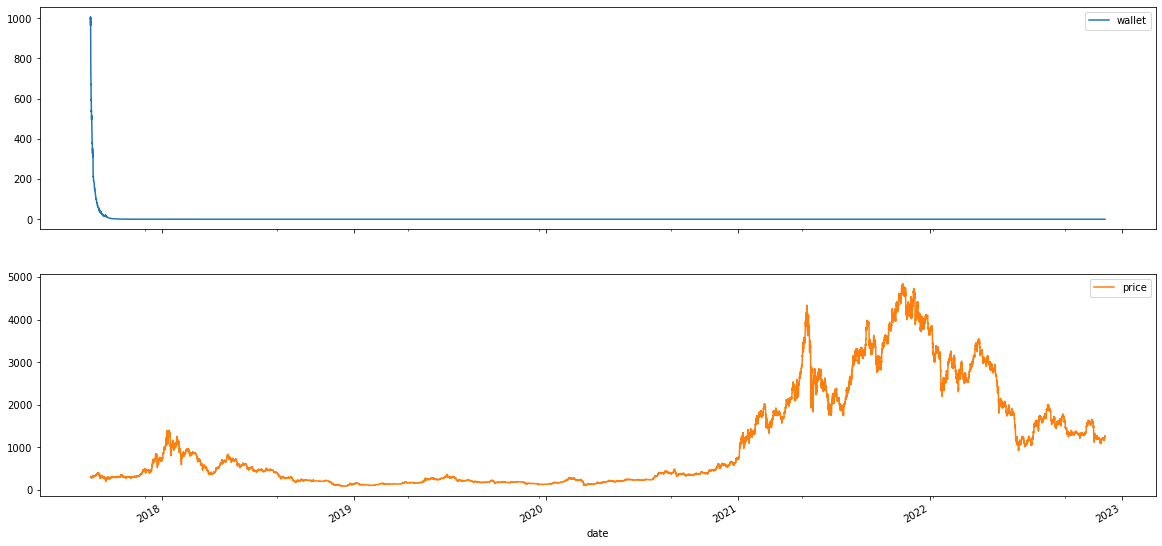

In [55]:
print("Pair Symbol :","ETH/USDT",)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Hold balance :", round(holdWallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage*100, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage*100, 2),
      "% | with Leverage :", round(holdPercentage*100, 2)*leverage, "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the ", idbest)
print("Worst trade :", worstTrade, "%, the ", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", TotalGoodTrades)
print("Number of negative trades : ", TotalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- LONG Trades Informations -----")
print("Number of LONG trades :",TotalLongTrades)
print("Average LONG trades performance :",AverageLongTrades, "%")
print("Best  LONG trade +"+bestLongTrade, "%, the ", idBestLong)
print("Worst LONG trade", worstLongTrade, "%, the ", idWorstLong)
print("Number of positive LONG trades :",totalGoodLongTrade)
print("Number of negative LONG trades :",totalBadLongTrade)
print("LONG trade win rate ratio :", round(totalGoodLongTrade/TotalLongTrades*100, 2), '%')

print("\n----- SHORT Trades Informations -----")
print("Number of SHORT trades :",TotalShortTrades)
print("Average SHORT trades performance :",AverageShortTrades, "%")
print("Best  SHORT trade +"+bestShortTrade, "%, the ", idBestShort)
print("Worst SHORT trade", worstShortTrade, "%, the ", idWorstShort)
print("Number of positive SHORT trades :",totalGoodShortTrade)
print("Number of negative SHORT trades :",totalBadShortTrade)
print("SHORT trade win rate ratio :", round(totalGoodShortTrade/TotalShortTrades*100, 2), '%')

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])
    
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")